# An example showing how different modules work

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
import sys
sys.path.append('../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2024-10-02 19:55:20.996448: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 19:55:20.996481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 19:55:20.997995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup experiment

In [112]:
# We need one place to save all the experiment relevant info.  
experiment_config= {'simulation_names':['P2L', 'DG'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':3, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated',
                                          'dhdy_widened_rotated',
                                          'filter_scale', 
                                          'uphp_rotated_nondim',
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' : ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated',
                                          'dhdy_widened_rotated',
                                          'filter_scale'],
                    
                    'output_channels' : ['uphp_rotated_nondim',
                                          'vphp_rotated_nondim'],
                    
                    'coeff_channels'  : [], 
        
                    'train_time_range': slice(0, 640),
                    'test_time_range' : slice(-64, None),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 

                    'num_inputs': 55, 
                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/test_ckpt'
                    
            }

## SimulationData Module
#### Load data for different simulations and prepare it with right variables and non-dims.

In this step all the variables and extra dimensions may be created that were not originally present. 
Each input and output variable gets its own containing variable (e.g. if top and bottom layer were two separate inputs, then in this step they may get separated out). 
Other examples might be that rotated variables, or magnitudes become their own variables in this step. 

In [113]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'])


In [114]:
DT.simulation_data

DataTree('None', parent=None)
├── DataTree('P2L')
│   ├── DataTree('50')
│   │       Dimensions:                      (Time: 7200, xh: 150, yh: 200, zl: 2, Xn: 3,
│   │                                         Yn: 3, zi: 3)
│   │       Coordinates:
│   │         * Time                         (Time) object 58kB 0001-01-11 00:00:00 ... 0...
│   │         * xh                           (xh) float64 1kB 4.0 12.0 ... 1.196e+03
│   │         * yh                           (yh) float64 2kB 4.0 12.0 ... 1.596e+03
│   │         * zl                           (zl) float64 16B 1.031e+03 1.033e+03
│   │         * zi                           (zi) float64 24B 1.03e+03 1.032e+03 1.034e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables: (12/40)
│   │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
│   │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
│   │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
│   │           dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
│   │           dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
│   │           dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
│   │           ...                           ...
│   │           dvdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
│   │           dvdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
│   │           dhdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
│   │           dhdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
│   │           uphp_rotated_nondim          (Time, zl, yh, xh) float64 3GB dask.array<chunksize=(36, 2, 199, 149), meta=np.ndarray>
│   │           vphp_rotated_nondim          (Time, zl, yh, xh) float64 3GB dask.array<chunksize=(36, 2, 199, 149), meta=np.ndarray>
│   │       Attributes:
│   │           simulation_name:  P2L
│   │           filter_scale:     50
│   │           source:           gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/r...
│   │           description:      Dataset for P2L experiment at 50 km resolution
│   ├── DataTree('100')
│   │       Dimensions:                      (Time: 7200, xh: 60, yh: 80, zl: 2, Xn: 3,
│   │                                         Yn: 3, zi: 3)
│   │       Coordinates:
│   │         * Time                         (Time) object 58kB 0001-01-11 00:00:00 ... 0...
│   │         * xh                           (xh) float64 480B 10.0 30.0 ... 1.19e+03
│   │         * yh                           (yh) float64 640B 10.0 30.0 ... 1.59e+03
│   │         * zl                           (zl) float64 16B 1.031e+03 1.033e+03
│   │         * zi                           (zi) float64 24B 1.03e+03 1.032e+03 1.034e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables: (12/40)
│   │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(36, 2, 79, 59, 3, 3), meta=np.ndarray>
│   │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(36, 2, 79, 59, 3, 3), meta=np.ndarray>
│   │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(36, 2, 79, 59, 3, 3), meta=np.ndarray>
│  

## MLXarrayDataset 

Go from simulation data to batchesm but still as Xarray objects. 
In this step things like dropping extra points, masking of data etc happen. 

In [115]:
ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['train_time_range'],
                                       num_batches = experiment_config['num_train_batches'])

Will load : 2.634752 gb into memory.
load took: 56.8706 seconds


In [116]:
ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config['all_ml_variables'],
                                      time_range=experiment_config['test_time_range'],
                                      num_batches = experiment_config['num_test_batches'])

Will load : 0.2634752 gb into memory.
load took: 7.4970 seconds


In [117]:
len(ML_DT_train.ml_batches), len(ML_DT_test.ml_batches) 

(37, 5)

In [118]:
ML_DT_train.ml_batches[0]

<xarray.Dataset> Size: 32MB
Dimensions:                      (Xn: 3, Yn: 3, points: 64761)
Coordinates:
  * points                       (points) object 518kB MultiIndex
  * Time                         (points) object 518kB 0009-01-29 00:00:00 .....
  * xh                           (points) float64 518kB 580.0 6.27 ... 680.0
  * yh                           (points) float64 518kB 964.0 45.36 ... 840.0
  * zl                           (points) float64 518kB 1.033e+03 ... 1.031e+03
Dimensions without coordinates: Xn, Yn
Data variables:
    dudx_widened_rotated_nondim  (Xn, Yn, points) float64 5MB -0.2342 ... 0.0...
    dvdx_widened_rotated_nondim  (Xn, Yn, points) float64 5MB 0.1437 ... 0.1121
    dudy_widened_rotated_nondim  (Xn, Yn, points) float64 5MB -0.1259 ... 0.1819
    dvdy_widened_rotated_nondim  (Xn, Yn, points) float64 5MB 0.2245 ... -0.0...
    dhdx_widened_rotated         (Xn, Yn, points) float64 5MB 0.003072 ... 0....
    dhdy_widened_rotated         (Xn, Yn, points) float64 5MB 0.0001738 ... -...
    filter_scale                 (points) float64 518kB 5e+04 1e+05 ... 4e+05
    uphp_rotated_nondim          (points) float64 518kB -4.497e-05 ... -1.235...
    vphp_rotated_nondim          (points) float64 518kB 4.005e-05 ... -5.014e-06
Attributes:
    simulation_name:  P2L
    filter_scale:     50
    source:           gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/r...
    description:      Dataset for P2L experiment at 50 km resolution

## MLJAXDataset 

### Convert these xbatcher batches to processed ones for training

This needs to take care of extra dims, like Xn,Yn.

In [119]:
import jax.numpy as jnp

In [120]:
batch_xr = ML_DT_train.ml_batches[0]

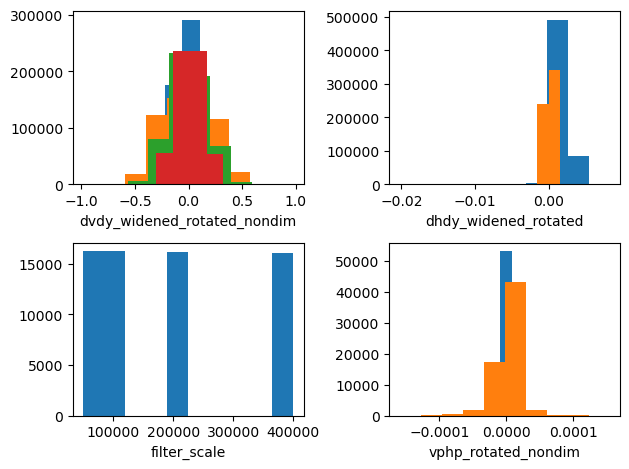

In [121]:
plt.subplot(221)
batch_xr[experiment_config['input_channels'][0]].plot.hist();
batch_xr[experiment_config['input_channels'][1]].plot.hist();
batch_xr[experiment_config['input_channels'][2]].plot.hist();
batch_xr[experiment_config['input_channels'][3]].plot.hist();

plt.subplot(222)
batch_xr[experiment_config['input_channels'][4]].plot.hist();
batch_xr[experiment_config['input_channels'][5]].plot.hist();

plt.subplot(223)
batch_xr[experiment_config['input_channels'][6]].plot.hist();

plt.subplot(224)
batch_xr[experiment_config['output_channels'][0]].plot.hist();
batch_xr[experiment_config['output_channels'][1]].plot.hist();

plt.tight_layout()

In [122]:
batch_xr.std()

<xarray.Dataset> Size: 72B
Dimensions:                      ()
Data variables:
    dudx_widened_rotated_nondim  float64 8B 0.1159
    dvdx_widened_rotated_nondim  float64 8B 0.2348
    dudy_widened_rotated_nondim  float64 8B 0.1692
    dvdy_widened_rotated_nondim  float64 8B 0.1164
    dhdx_widened_rotated         float64 8B 0.001318
    dhdy_widened_rotated         float64 8B 0.0003907
    filter_scale                 float64 8B 1.339e+05
    uphp_rotated_nondim          float64 8B 1.026e-05
    vphp_rotated_nondim          float64 8B 1.672e-05

In [123]:
# Define the variables and assign normalizations 

normalize_data_dic = {
    'dudx': ([], 1e-6),  # scalar value
    'dvdx': ([], 1e-6),
    'dudy': ([], 1e-6),
    'dvdy': ([], 1e-6),
    'dhdx': ([], 1e-3),
    'dhdy': ([], 1e-3),
    'filter_scale': ([], 140e3),
    'uphp': ([], 4.),
    'vphp': ([], 4.),
    'dudx_widened': ([], 1e-6),  # scalar value
    'dvdx_widened': ([], 1e-6),
    'dudy_widened': ([], 1e-6),
    'dvdy_widened': ([], 1e-6),
    'dhdx_widened': ([], 1e-3),
    'dhdy_widened': ([], 1e-3),
    'dhdx_widened_rotated': ([], 1e-3),
    'dhdy_widened_rotated': ([], 1e-3),
    
    'dudx_widened_rotated_nondim': ([], 1e-1),  # scalar value
    'dvdx_widened_rotated_nondim': ([], 1e-1),
    'dudy_widened_rotated_nondim': ([], 1e-1),
    'dvdy_widened_rotated_nondim': ([], 1e-1),
    'dhdx_widened_rotated_nondim': ([], 1e-1),
    'dhdy_widened_rotated_nondim': ([], 1e-1),
    'uphp_rotated_nondim': ([], 1e-5),
    'vphp_rotated_nondim': ([], 1e-5),
}

# Eventually would be good to save this normalization factors dictionary with the one
# that keeps all the experiment config information. 


ds_norm = xr.Dataset(normalize_data_dic)

In [124]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'], 
                                      ds_norm=ds_norm)

In [125]:
test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'],
                                      ds_norm=ds_norm)

In [126]:
ML_data_combo = {'train_data':train_ML_data, 'test_data':test_ML_data}

In [127]:
for batch_out in ML_data_combo['train_data'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (64761, 55)
Output (y) batch shape: (64761, 2)


## AnnRegressionSystem (and associated NN setup modules ArtificialNeuralNetwork and PointwiseANN).


In [128]:
num_in = batch_out['X'].shape[-1]
num_in

55

In [129]:
ANN_model = ML_classes.PointwiseANN(num_in = experiment_config['num_inputs'],
                                    shape = experiment_config['network_shape']) 

In [130]:
ANN_model.count_parameters()

3422


In [131]:
regress_sys = ML_classes.AnnRegressionSystem(ANN_model)

In [132]:
%%time 
regress_sys.train_system(ML_data_combo, num_epoch=41, print_freq=2)

At epoch 1. Train loss :  1.355277396537162 , Test loss: 1.1406219005584717
At epoch 3. Train loss :  0.7630700823423024 , Test loss: 0.7237728476524353
At epoch 5. Train loss :  0.6115434959128097 , Test loss: 0.6141760945320129
At epoch 7. Train loss :  0.545074047269048 , Test loss: 0.5535207033157349
At epoch 9. Train loss :  0.5171640015937187 , Test loss: 0.5380546689033509
At epoch 11. Train loss :  0.4859703046244544 , Test loss: 0.5075257182121277
At epoch 13. Train loss :  0.4722916749683586 , Test loss: 0.4885919988155365
At epoch 15. Train loss :  0.46353687788989095 , Test loss: 0.47424607872962954
At epoch 17. Train loss :  0.4553583948998838 , Test loss: 0.46364066004753113
At epoch 19. Train loss :  0.45156484600659963 , Test loss: 0.4575233101844788
At epoch 21. Train loss :  0.43557110026076035 , Test loss: 0.45044422149658203
At epoch 23. Train loss :  0.4328698209814123 , Test loss: 0.4532416820526123
At epoch 25. Train loss :  0.4203625103911838 , Test loss: 0.4504

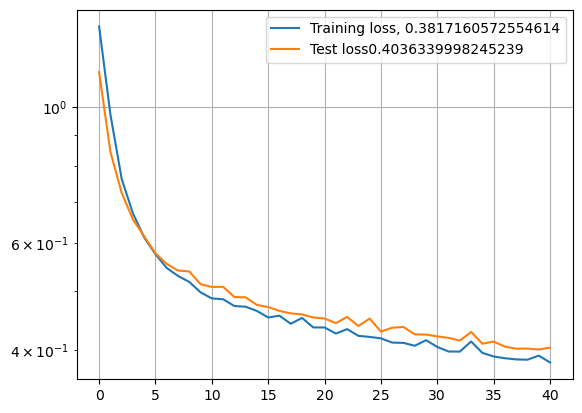

In [133]:
## Loss plot
plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

plt.grid()
plt.yscale('log')
plt.legend()

In [134]:
regress_sys.save_checkpoint(experiment_config['exp_ckpt_save_dir'])

Testing around saving check points 

Check if data can be reloaded in, we do this in a new object.

In [135]:
new_regress_sys =  ML_classes.AnnRegressionSystem(ANN_model)

In [136]:
new_regress_sys.read_checkpoint(experiment_config['exp_ckpt_save_dir'])

Making predictions using some batch. 

In [137]:
y_true = batch_out['y']

In [138]:
y_pred = new_regress_sys.pred(batch_out['X'], batch_out['Xp'])

In [139]:
y_pred

Array([[-4.495034  ,  3.7580087 ],
       [-1.2146335 ,  0.25503755],
       [-3.2507293 , -1.7965839 ],
       ...,
       [-2.4047515 , -1.0670118 ],
       [ 0.72942793, -7.6796527 ],
       [-2.007682  , -1.2583443 ]], dtype=float32)

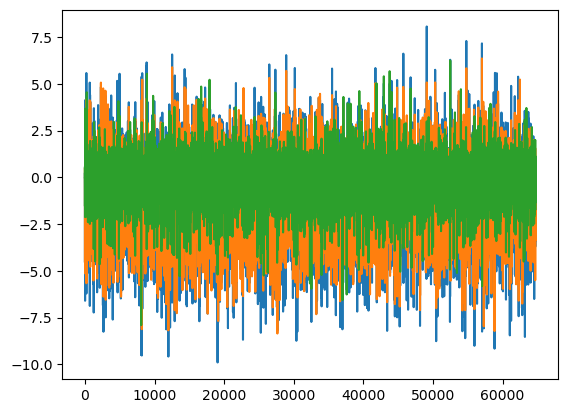

In [140]:
plt.plot(y_true[:,0])
plt.plot(y_pred[:,0])
plt.plot(y_true[:,0]- y_pred[:,0])

The above prediction method works, but we would like a little more functionality. 
We want to be able to make predictions on the original grids and structure of the data (e.g. at different scales), so we can track performance in real space (rather than sample space). To do all this, we will be developing an evaluation module. 

## Evaluation Module

In [141]:
DT

In [142]:
test_eval = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config['input_channels'],
                                 output_channels=experiment_config['output_channels'], 
                                 coeff_channels=experiment_config['coeff_channels'], 
                                 ds_norm_factors=ds_norm,
                                 eval_time_slice=slice(1000, 1010), 
                                 num_inputs=experiment_config['num_inputs'], 
                                 shape=experiment_config['network_shape'], 
                                 ckpt_dir=experiment_config['exp_ckpt_save_dir'])

In [143]:
test_eval.read_ann_regression_model()

In [144]:
test_eval.read_eval_data()

In [145]:
test_eval.eval_datatree.ml_dataset

DataTree('None', parent=None)
├── DataTree('P2L')
│   ├── DataTree('50')
│   │       Dimensions:                      (Time: 10, zl: 2, yh: 200, xh: 150, Xn: 3,
│   │                                         Yn: 3)
│   │       Coordinates:
│   │         * Time                         (Time) object 80B 0028-05-29 00:00:00 ... 00...
│   │         * xh                           (xh) float64 1kB 4.0 12.0 ... 1.196e+03
│   │         * yh                           (yh) float64 2kB 4.0 12.0 ... 1.596e+03
│   │         * zl                           (zl) float64 16B 1.031e+03 1.033e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables:
│   │           dudx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 43MB dask.array<chunksize=(8, 2, 199, 149, 3, 3), meta=np.ndarray>
│   │           dvdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 43MB dask.array<chunksize=(8, 2, 199, 149, 3, 3), meta=np.ndarray>
│   │           dudy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 43MB dask.array<chunksize=(8, 2, 199, 149, 3, 3), meta=np.ndarray>
│   │           dvdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 43MB dask.array<chunksize=(8, 2, 199, 149, 3, 3), meta=np.ndarray>
│   │           dhdx_widened_rotated         (Time, zl, yh, xh, Xn, Yn) float64 43MB dask.array<chunksize=(8, 2, 199, 149, 3, 3), meta=np.ndarray>
│   │           dhdy_widened_rotated         (Time, zl, yh, xh, Xn, Yn) float64 43MB dask.array<chunksize=(8, 2, 199, 149, 3, 3), meta=np.ndarray>
│   │           filter_scale                 (Time, zl, yh, xh) float64 5MB dask.array<chunksize=(8, 2, 200, 150), meta=np.ndarray>
│   │           uphp_rotated_nondim          (Time, zl, yh, xh) float64 5MB dask.array<chunksize=(8, 2, 199, 149), meta=np.ndarray>
│   │           vphp_rotated_nondim          (Time, zl, yh, xh) float64 5MB dask.array<chunksize=(8, 2, 199, 149), meta=np.ndarray>
│   │           h_mask                       (Time, zl, yh, xh) bool 600kB dask.array<chunksize=(8, 2, 200, 150), meta=np.ndarray>
│   │       Attributes:
│   │           simulation_name:  P2L
│   │           filter_scale:     50
│   │           source:           gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/r...
│   │           description:      Dataset for P2L experiment at 50 km resolution
│   ├── DataTree('100')
│   │       Dimensions:                      (Time: 10, zl: 2, yh: 80, xh: 60, Xn: 3, Yn: 3)
│   │       Coordinates:
│   │         * Time                         (Time) object 80B 0028-05-29 00:00:00 ... 00...
│   │         * xh                           (xh) float64 480B 10.0 30.0 ... 1.19e+03
│   │         * yh                           (yh) float64 640B 10.0 30.0 ... 1.59e+03
│   │         * zl                           (zl) float64 16B 1.031e+03 1.033e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables:
│   │           dudx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
│   │           dvdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
│   │           dudy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
│   │           dvdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
│   │           dhdx_widened_rotated         (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
│   │           dhdy_widened_rotated         (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
│   │           filter_scale                 (Time, zl, yh, xh) float64 768kB dask.array<chunksize=(8, 2, 80, 60), meta=np.ndarray>
│   │           uphp_rotated_nondim          (Time, zl, yh, xh) float64 768kB dask.array<ch

In [146]:
test_eval.predict()

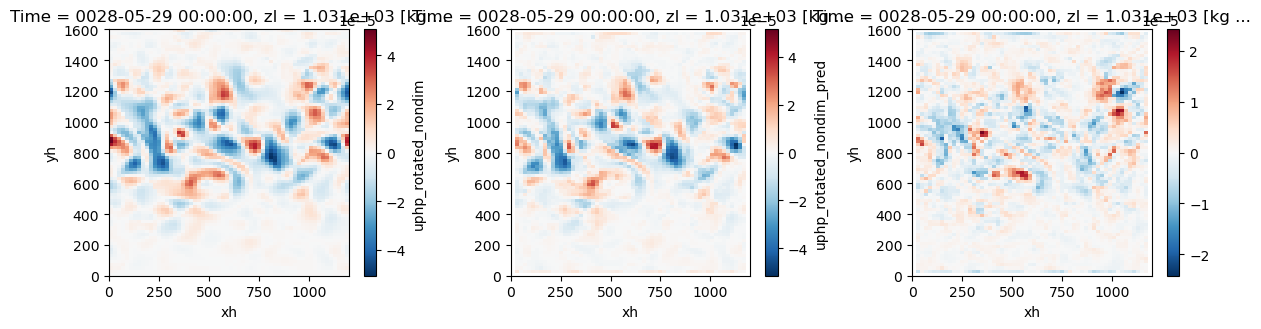

In [148]:
plt.figure(figsize=(12, 3.4))

plt.subplot(131)
test_eval.eval_datatree.ml_dataset['P2L']['100'][experiment_config['output_channels'][0]].isel(Time=0, zl=0).plot()

plt.subplot(132)
test_eval.eval_datatree.ml_dataset['P2L']['100'][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=0).plot()

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset['P2L']['100'][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset['P2L']['100'][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=0).plot()

plt.tight_layout()

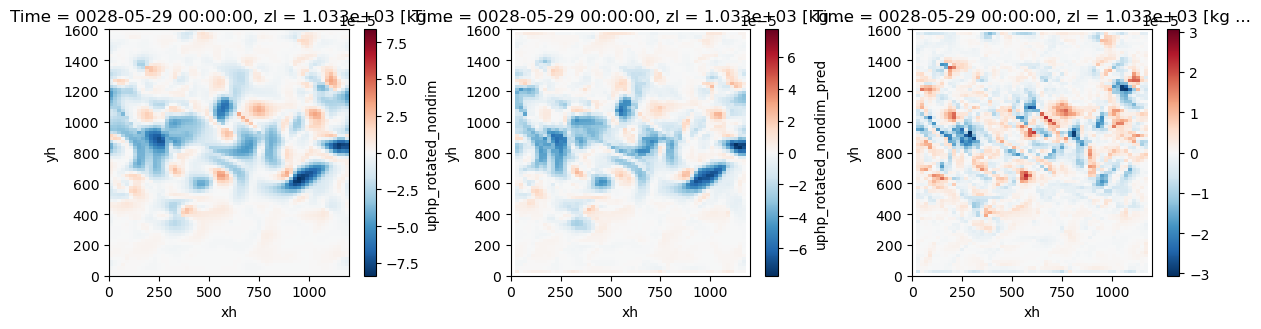

In [149]:
plt.figure(figsize=(12, 3.4))
zl_choice = 1

plt.subplot(131)
test_eval.eval_datatree.ml_dataset['P2L']['100'][experiment_config['output_channels'][0]].isel(Time=0, zl=zl_choice).plot()

plt.subplot(132)
test_eval.eval_datatree.ml_dataset['P2L']['100'][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl_choice).plot()

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset['P2L']['100'][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset['P2L']['100'][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl_choice).plot()

plt.tight_layout()

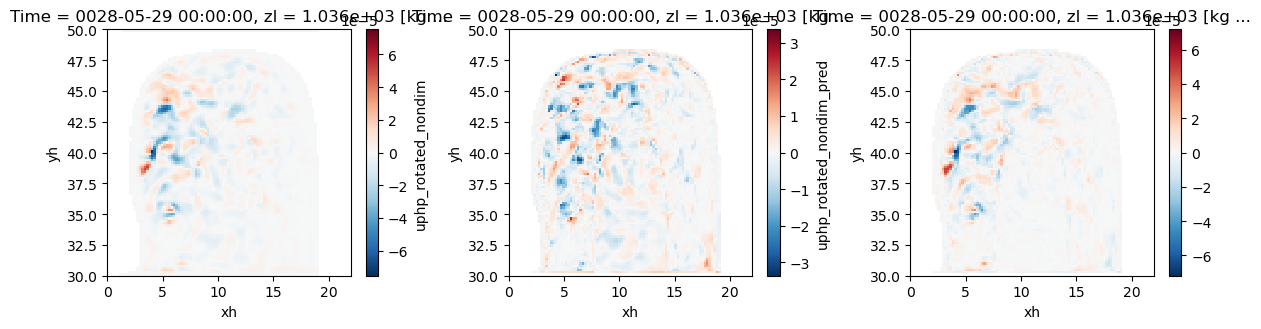

In [152]:
plt.figure(figsize=(12, 3.4))
zl_choice = 1
exp='DG'

plt.subplot(131)
test_eval.eval_datatree.ml_dataset[exp]['100'][experiment_config['output_channels'][0]].isel(Time=0, zl=zl_choice).plot()

plt.subplot(132)
test_eval.eval_datatree.ml_dataset[exp]['100'][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl_choice).plot()

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset[exp]['100'][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset[exp]['100'][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl_choice).plot()

plt.tight_layout()

In [36]:
Eval_DT = datasets.MLXarrayDataset(simulation_data=DT, # Note that this DT does not need to be the same as what was initiated to train the model
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=slice(100, 110),
                                      default_create=False)

In [37]:
Eval_DT.choose_ml_variables()
Eval_DT.subsample_ml_variables_time()

In [39]:
Eval_DT.ml_dataset

DataTree('None', parent=None)
└── DataTree('P2L')
    ├── DataTree('50')
    │       Dimensions:       (Time: 10, zl: 2, yh: 200, xh: 150, Xn: 3, Yn: 3)
    │       Coordinates:
    │         * Time          (Time) object 80B 0003-10-08 00:00:00 ... 0004-01-06 00:00:00
    │         * xh            (xh) float64 1kB 4.0 12.0 20.0 ... 1.188e+03 1.196e+03
    │         * yh            (yh) float64 2kB 4.0 12.0 20.0 ... 1.588e+03 1.596e+03
    │         * zl            (zl) float64 16B 1.031e+03 1.033e+03
    │       Dimensions without coordinates: Xn, Yn
    │       Data variables:
    │           dudx_widened  (Time, zl, yh, xh, Xn, Yn) float64 43MB dask.array<chunksize=(8, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dvdx_widened  (Time, zl, yh, xh, Xn, Yn) float64 43MB dask.array<chunksize=(8, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dudy_widened  (Time, zl, yh, xh, Xn, Yn) float64 43MB dask.array<chunksize=(8, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dvdy_widened  (Time, zl, yh, xh, Xn, Yn) float64 43MB dask.array<chunksize=(8, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dhdx_widened  (Time, zl, yh, xh, Xn, Yn) float64 43MB dask.array<chunksize=(8, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dhdy_widened  (Time, zl, yh, xh, Xn, Yn) float64 43MB dask.array<chunksize=(8, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           filter_scale  (Time, zl, yh, xh) float64 5MB dask.array<chunksize=(8, 2, 200, 150), meta=np.ndarray>
    │           uphp          (Time, zl, yh, xh) float32 2MB dask.array<chunksize=(8, 2, 200, 150), meta=np.ndarray>
    │           vphp          (Time, zl, yh, xh) float32 2MB dask.array<chunksize=(8, 2, 200, 150), meta=np.ndarray>
    │           h_mask        (Time, zl, yh, xh) bool 600kB dask.array<chunksize=(8, 2, 200, 150), meta=np.ndarray>
    │       Attributes:
    │           simulation_name:  P2L
    │           filter_scale:     50
    │           source:           gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/r...
    │           description:      Dataset for P2L experiment at 50 km resolution
    ├── DataTree('100')
    │       Dimensions:       (Time: 10, zl: 2, yh: 80, xh: 60, Xn: 3, Yn: 3)
    │       Coordinates:
    │         * Time          (Time) object 80B 0003-10-08 00:00:00 ... 0004-01-06 00:00:00
    │         * xh            (xh) float64 480B 10.0 30.0 50.0 ... 1.17e+03 1.19e+03
    │         * yh            (yh) float64 640B 10.0 30.0 50.0 ... 1.57e+03 1.59e+03
    │         * zl            (zl) float64 16B 1.031e+03 1.033e+03
    │       Dimensions without coordinates: Xn, Yn
    │       Data variables:
    │           dudx_widened  (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
    │           dvdx_widened  (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
    │           dudy_widened  (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
    │           dvdy_widened  (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
    │           dhdx_widened  (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
    │           dhdy_widened  (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
    │           filter_scale  (Time, zl, yh, xh) float64 768kB dask.array<chunksize=(8, 2, 80, 60), meta=np.ndarray>
    │           uphp          (Time, zl, yh, xh) float32 384kB dask.array<chunksize=(8, 2, 80, 60), meta=np.ndarray>
    │           vphp          (Time, zl, yh, xh) float32 384kB dask.array<chunksize=(8, 2, 80, 60), meta=np.ndarray>
    │           h_mask        (Time, zl, yh, xh) bool 96kB dask.array<chunksize=(8, 2, 80, 60), meta=np.ndarray>
    │       Attributes:
    │           simulation_name:  P2L
    │           filter_scale:     100
    │    

In [62]:
experiment_config['all_ml_variables'] + experiment_config['input_channels'] + None

TypeError: can only concatenate list (not "NoneType") to list

In [77]:
ml_ds = Eval_DT.ml_dataset['P2L']['100','200'].to_dataset()

In [78]:
ml_ds

<xarray.Dataset> Size: 43MB
Dimensions:       (Time: 10, zl: 2, yh: 80, xh: 60, Xn: 3, Yn: 3)
Coordinates:
  * Time          (Time) object 80B 0003-10-08 00:00:00 ... 0004-01-06 00:00:00
  * xh            (xh) float64 480B 10.0 30.0 50.0 ... 1.17e+03 1.19e+03
  * yh            (yh) float64 640B 10.0 30.0 50.0 ... 1.57e+03 1.59e+03
  * zl            (zl) float64 16B 1.031e+03 1.033e+03
Dimensions without coordinates: Xn, Yn
Data variables:
    dudx_widened  (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
    dvdx_widened  (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
    dudy_widened  (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
    dvdy_widened  (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
    dhdx_widened  (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
    dhdy_widened  (Time, zl, yh, xh, Xn, Yn) float64 7MB dask.array<chunksize=(8, 2, 79, 59, 3, 3), meta=np.ndarray>
    filter_scale  (Time, zl, yh, xh) float64 768kB dask.array<chunksize=(8, 2, 80, 60), meta=np.ndarray>
    uphp          (Time, zl, yh, xh) float32 384kB dask.array<chunksize=(8, 2, 80, 60), meta=np.ndarray>
    vphp          (Time, zl, yh, xh) float32 384kB dask.array<chunksize=(8, 2, 80, 60), meta=np.ndarray>
    h_mask        (Time, zl, yh, xh) bool 96kB dask.array<chunksize=(8, 2, 80, 60), meta=np.ndarray>
Attributes:
    simulation_name:  P2L
    filter_scale:     100
    source:           gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/r...
    description:      Dataset for P2L experiment at 100 km resolution

In [79]:
input_ds = ml_ds[experiment_config['input_channels']]
output_ds = ml_ds[experiment_config['output_channels']]

In [114]:
input_normed_ds = input_ds/ds_norm

In [115]:
output_normed_ds = output_ds/ds_norm

In [116]:
X_xr = input_normed_ds.to_stacked_array("input_features", sample_dims=['Time', 'zl', 'yh', 'xh'])

In [117]:
y_xr = output_normed_ds.to_array().transpose('Time', 'zl', 'yh', 'xh', 'variable')

In [118]:
Xp_xr = 0. * y_xr.copy() + 1.

In [119]:
y_pred_xr = regress_sys.pred(X_xr, Xp_xr)

In [120]:
pred_xr = y_pred_xr.to_dataset(dim='variable')

In [123]:
pred_denormed_xr = pred_xr * ds_norm

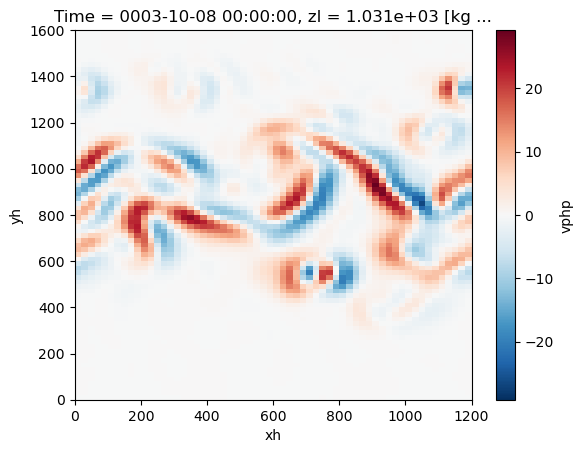

In [121]:
output_ds.vphp.isel(Time=0, zl=0).plot()

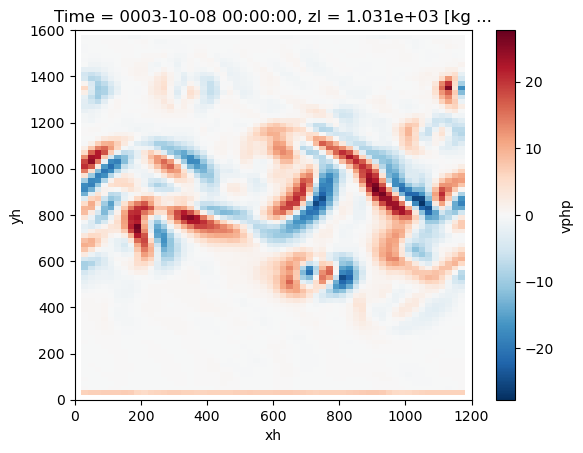

In [124]:
pred_denormed_xr.vphp.isel(Time=0, zl=0).plot()